In [1]:
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import pandas as pd
from fooof import FOOOF, FOOOFGroup, fit_fooof_3d
from fooof.sim.gen import gen_aperiodic
from mne.io import read_epochs_eeglab
from sklearn.neighbors import KernelDensity
import pyreadstat

In [2]:
plt.rcParams.update({
    'font.size': 14,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})

In [3]:
pipeline='NEARICA_behav'
c_cluster_chans=['C3', 'C4']
n_chans=31
excluded_subjects=np.array(['C34','C36'])

In [4]:
df, meta = pyreadstat.read_sav('/home/bonaiuto/dcd_ross/CoMB_Dataset.sav')

In [5]:
df.head()

,SubjectID,Excluded,Group,DOB,DOT,Age,Sex,Handedness,AddDiag,MABCPercent,...,Dur_ExcGross,WinSize,Overlap,ArtThresh,filter_$,Log10Kal,Alpha_Central_EO,Alpha_Central_EC,Alpha_Occipital_EO,Alpha_Occipital_EC
0,C03,0.0,0.0,2012-09-01,2021-04-01,8.58,0.0,1.0,0.0,3.0,...,160.08,512.0,0.5,175.0,1.0,1.293617,48.611789,95.146,189.573915,687.460
1,C04,0.0,0.0,2009-10-27,2021-04-08,11.42,0.0,1.0,0.0,3.0,...,152.07,512.0,0.5,175.0,1.0,1.036387,30.463039,80.068,137.210574,827.800
2,C05,0.0,0.0,2012-09-03,2021-04-09,8.58,0.0,1.0,0.0,3.0,...,152.07,512.0,0.5,175.0,1.0,1.522474,66.285612,96.651,148.650861,383.446
3,C06,3.0,0.0,2011-02-11,2021-04-17,10.17,1.0,1.0,0.0,2.0,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,C07,3.0,0.0,2012-02-16,2021-04-17,9.17,1.0,1.0,0.0,2.0,...,160.08,512.0,0.5,175.0,1.0,1.185000,62.541530,80.609,56.114967,239.852


In [6]:
list(df.keys())

['SubjectID',
 'Excluded',
 'Group',
 'DOB',
 'DOT',
 'Age',
 'Sex',
 'Handedness',
 'AddDiag',
 'MABCPercent',
 'MABC_TestScore',
 'MABC_StdScore',
 'MABC_Percentile',
 'MABC_ManDexTotalScore',
 'MABC_ManDexStdScore',
 'MABC_ManDexPercentile',
 'MABC_AimingTotalScore',
 'MABC_AimingStdScore',
 'MABC_AimingPercentile',
 'MABC_BalanceTotalScore',
 'MABC_BalanceStdScore',
 'MABC_BalancePercentile',
 'FSIQ2_Vocab',
 'FSIQ2_MatrixReasoning',
 'FSIQ2_CompositeScore',
 'FSIQ2_Percentile',
 'SNAP_Inatt',
 'SNAP_HypImp',
 'SNAP_ODD',
 'SNAP_Total',
 'SNAP_ADHD',
 'SCQ_Total',
 'SEQ_Hyper',
 'SEQ_Hypo',
 'SEQ_SIRS',
 'SEQ_EP',
 'SEQ_Auditory',
 'SEQ_Visual',
 'SEQ_Tactile',
 'SEQ_GustOlf',
 'SEQ_VestProp',
 'TrSEQHypo',
 'TrSEQSIRS',
 'TrSCQTotal',
 'TrSEQEP',
 'TrSEQVisual',
 'TrSEQVestProp',
 'tom_early',
 'tom_basic',
 'tom_advanced',
 'tom_emotionrecognition',
 'tom_mentalstate',
 'tom_pragmatics',
 'tom_total',
 'DFT_Kal',
 'DFT_ObsFine',
 'DFT_ObsGross',
 'DFT_ExcFine',
 'DFT_ExcGross',
 

In [7]:
len(np.where(df['MABC_Percentile'][df['Group']==0]<25)[0])

9

In [8]:
df['SubjectID'][np.where((df['MABC_Percentile']<25) & (df['Group']==0))[0]]

3     C06
4     C07
5     C08
28    C31
29    C32
32    C35
36    C39
52    C55
55    C58
Name: SubjectID, dtype: object

In [9]:
def compute_psds(epoch_type, group=None):
    # Load the SPSS file containing group information
    df, _ = pyreadstat.read_sav('/home/bonaiuto/dcd_ross/CoMB_Dataset.sav')
    
    # Load the participants data
    subjects = pd.read_csv('/home/bonaiuto/dcd_ross/data/participants.tsv', sep='\t')

    # Get the SubjectID values that correspond to the selected group
    subject_ids = subjects['participant_id']

    sub_psds = []
    sub_psd_ids = []
    for subj_id in subject_ids:
        subj_group=df['Group'][np.where(df['SubjectID']==subj_id)[0]].values[0]
        if group is None or subj_group==group:
            if group is None:
                group=subj_group
            
            mab_per=df['MABC_Percentile'][np.where(df['SubjectID']==subj_id)[0]].values[0]        
            if not ((group==0 and mab_per<25) or len(np.where(excluded_subjects==subj_id)[0])):
                subject_data_fname = op.join('/home/bonaiuto/dcd_ross/data/derivatives', pipeline, 
                                             subj_id, 'processed_data', '{}_{}.set'.format(subj_id, epoch_type))
                if op.exists(subject_data_fname):
                    EEG = read_epochs_eeglab(subject_data_fname)
                    srate = EEG.info['sfreq']

                    c_chan_idx = []
                    for chan in c_cluster_chans:
                        c_chan_idx.append(EEG.info['ch_names'].index(chan))

                    data = EEG.get_data()
                    n_trials = data.shape[0]
                    n_chans = data.shape[1]
                    n_samps = data.shape[2]

                    # Use a window size of 1s with a 50% overlap
                    winsize = srate
                    overlap = int(winsize / 2)    

                    chan_psd = np.zeros((n_chans, 401))
                    for chan in range(n_chans):
                        chan_data = data[:, chan, :]

                        freqs, psd = scipy.signal.welch(chan_data, fs=srate, window='hann', 
                                                        nperseg=winsize, noverlap=overlap, nfft=2000, detrend='constant',
                                                        return_onesided=True, scaling='density', axis=-1, average='mean')
                        #f_idx = (freqs >= 0.1) & (freqs <= 100)
                        f_idx = (freqs <= 100)
                        freqs = freqs[f_idx]
                        psd = psd[:, f_idx]
                        chan_psd[chan, :] = np.mean(psd, axis=0)        
                    sub_psds.append(chan_psd)
                    sub_psd_ids.append(subj_id)
            else:
                print(f'skipping {subj_id}')

    sub_psds = np.array(sub_psds)
    return c_chan_idx, freqs, sub_psds, sub_psd_ids

In [10]:
def parameterize_psds(freqs, sub_psds):
    fg = FOOOFGroup()
    fgs=fit_fooof_3d(fg, freqs, sub_psds, [0, 100])
    
    sub_periodic=np.zeros(sub_psds.shape)
    sub_aperiodic=np.zeros(sub_psds.shape)
    for s_idx, fg in enumerate(fgs):
        for chan in range(n_chans):
            if chan in fg.null_inds_:
                sub_aperiodic[s_idx,chan,:]=float('NaN')
                sub_periodic[s_idx,chan,:]=float('NaN')
            else:
                fm = fg.get_fooof(ind=chan, regenerate=True)
                ap_params=fm.get_params('aperiodic_params')
                sub_aperiodic[s_idx,chan,:] = gen_aperiodic(freqs, ap_params)
                sub_periodic[s_idx,chan,:]=np.log10(sub_psds[s_idx,chan,:])-sub_aperiodic[s_idx,chan,:]
    return fgs, sub_periodic, sub_aperiodic

In [11]:
def define_fois(freqs, mean_psd, debug=False):
    mean_resid=mean_psd
    foi_pk_freqs=[]
    foi_pk_vals=[]    
    foi_fwhms=[]
    foi_ranges=[]
    orig_pks,properties=scipy.signal.find_peaks(mean_resid)
    while True:
        pks,properties=scipy.signal.find_peaks(mean_resid)

        if len(pks)==0:
            break
        pk_vals=mean_resid[pks]
        sorted_idx=np.argsort(-pk_vals)
        pk_vals=pk_vals[sorted_idx]
        pks=pks[sorted_idx]

        pk_idx=pks[0]
        pk_val=pk_vals[0]
        pk_freq=freqs[pk_idx]
        
        if pk_val<np.std(mean_resid):
            if debug:
                print('Peak val={}, thresh={}'.format(pk_val,.5*np.std(mean_resid)))
            break

        
        l_idx=np.where(mean_resid[:pk_idx]<=pk_val*.5)[0]
        r_idx=np.where(mean_resid[pk_idx:]<=pk_val*.5)[0]

        if len(l_idx) and len(r_idx):
            l_freq=freqs[l_idx[-1]]
            r_freq=freqs[pk_idx+r_idx[0]]
            r_side=(r_freq-pk_freq)
            l_side=(pk_freq-l_freq)
            fwhm=2*np.min([r_side, l_side])
        elif len(l_idx):
            l_freq=freqs[l_idx[-1]]
            fwhm=2*(pk_freq-l_freq)
        elif len(r_idx):
            r_freq=freqs[pk_idx+r_idx[0]+1]
            fwhm=2*(r_freq-pk_freq)

        l_freq=pk_freq-fwhm*.5
        r_freq=pk_freq+fwhm*.5
        sd=fwhm/(2*np.sqrt(2*np.log(2)))
        A=pk_vals[0]*np.exp(-.5*((freqs-pk_freq)/sd)**2)
        nearest_orig=np.min(np.abs(freqs[np.array(orig_pks)]-pk_freq))
            
        if pk_val>1.75*np.std(mean_resid) and ((pk_freq<10 and fwhm>2) or (pk_freq>=10 and fwhm>3)):# and nearest_orig<3:
            print('Peak: freq={}, val={}, width={}, range={}-{}'.format(pk_freq, pk_val, fwhm, pk_freq-fwhm*.5, pk_freq+fwhm*.5))
            print('Distance to nearest original peak={}'.format(nearest_orig))
            if debug:
                plt.figure(figsize=(12,4))
                plt.subplot(1,2,1)
                plt.plot(freqs,mean_resid)
                plt.plot(freqs[pks],mean_resid[pks],'ro')
                plt.subplot(1,2,2)
                plt.plot(freqs,mean_resid)
                plt.plot(freqs,A)
            
            foi_pk_freqs.append(pk_freq)
            foi_pk_vals.append(pk_val)
            foi_fwhms.append(fwhm)
            foi_ranges.append([l_freq,r_freq])
        elif debug:
            if not ((pk_freq<10 and fwhm>1) or (pk_freq>=10 and fwhm>3)):
                print('Peak: freq={}, fhwm={} to narrow'.format(pk_freq, fwhm))
            if pk_val<=2*np.std(mean_resid):
                print('Peak: freq={} too low amplitude'.format(pk_freq))
            #if nearest_orig>=3:
            #    print('Peak: freq={} too far from original peaks'.format(pk_freq))

        mean_resid=mean_resid-A
        mean_resid[mean_resid<0]=0
    sorted_idx=np.argsort(foi_pk_freqs)
    
    foi_pk_freqs=np.array(foi_pk_freqs)
    foi_pk_vals=np.array(foi_pk_vals)
    foi_fwhms=np.array(foi_fwhms)
    foi_ranges=np.array(foi_ranges)
    
    foi_pk_freqs=foi_pk_freqs[sorted_idx]
    foi_pk_vals=foi_pk_vals[sorted_idx]
    foi_fwhms=foi_fwhms[sorted_idx]
    foi_ranges=foi_ranges[sorted_idx,:]
    
    plt.figure()
    bands=['theta','alpha','low beta', 'high beta']
    plt.plot(freqs,mean_psd)
    for f_idx in range(foi_ranges.shape[0]):
        sd=foi_fwhms[f_idx]/(2*np.sqrt(2*np.log(2)))
        A=foi_pk_vals[f_idx]*np.exp(-.5*((freqs-foi_pk_freqs[f_idx])/sd)**2)
        plt.plot(freqs,A)#,label=bands[f_idx])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.legend()
    
    return foi_pk_freqs,foi_pk_vals,foi_fwhms,foi_ranges

In [12]:
c_chan_idx, freqs, sub_psds_eye_typ, sub_eye_typ_ids=compute_psds('eye', group=0)
c_chan_idx, freqs, sub_psds_eye_dcd, sub_eye_dcd_ids=compute_psds('eye', group=1)

c_chan_idx, freqs, sub_psds_task_typ, sub_task_typ_ids=compute_psds('task', group=0)
c_chan_idx, freqs, sub_psds_task_dcd, sub_task_dcd_ids=compute_psds('task', group=1)

Extracting parameters from /home/bonaiuto/dcd_ross/data/derivatives/NEARICA_behav_v3/C03/processed_data/C03_eye.set...
Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bonaiuto/dcd_ross/data/derivatives/NEARICA_behav_v3/C04/processed_data/C04_eye.set...
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bonaiuto/dcd_ross/data/derivatives/NEARICA_behav_v3/C05/processed_data/C05_eye.set...
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
Ready.
skipping C06
skipping C07
skipping C08
Extracting parameters from /home/bonaiuto/dcd_ross/data/derivatives/NEARICA_behav_v3/C09/processed_data/C09_eye.set...
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bona

Ready.
Extracting parameters from /home/bonaiuto/dcd_ross/data/derivatives/NEARICA_behav_v3/C46/processed_data/C46_eye.set...
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bonaiuto/dcd_ross/data/derivatives/NEARICA_behav_v3/C49/processed_data/C49_eye.set...
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bonaiuto/dcd_ross/data/derivatives/NEARICA_behav_v3/C56/processed_data/C56_eye.set...
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bonaiuto/dcd_ross/data/derivatives/NEARICA_behav_v3/C03/processed_data/C03_task.set...
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bonaiuto/dcd_ross/data/derivatives

No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bonaiuto/dcd_ross/data/derivatives/NEARICA_behav_v3/C20/processed_data/C20_task.set...
Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bonaiuto/dcd_ross/data/derivatives/NEARICA_behav_v3/C25/processed_data/C25_task.set...
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bonaiuto/dcd_ross/data/derivatives/NEARICA_behav_v3/C26/processed_data/C26_task.set...
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bonaiuto/dcd_ross/data/derivatives/NEARICA_behav_v3/C27/processed_data/C27_task.set...
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Ready.
E

In [13]:
sub_psds_typ=np.vstack([sub_psds_eye_typ, sub_psds_task_typ])
sub_psds_dcd=np.vstack([sub_psds_eye_dcd, sub_psds_task_dcd])

In [14]:
fgs_typ, sub_periodic_typ, sub_aperiodic_typ=parameterize_psds(freqs, sub_psds_eye_typ)
fgs_dcd, sub_periodic_dcd, sub_aperiodic_dcd=parameterize_psds(freqs, sub_psds_eye_dcd)


FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.
Running FOOOFGroup across 31 power spectra.

FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.
Running FOOOFGroup across 31 power spectra.

FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.
Running FOOOFGroup across 31 power spectra.

FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.
Running FOOOFGroup across 31 power spectra.

FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.
Running FOOOFGroup across 31 power spectra.

FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.
Running FOOOFGroup across 31 power spectra.

FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.
Running FOOOFGroup across 31 power spectra.

FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.
Running FOOOFGroup across 31 power spectra.

FOOOF W

/home/bonaiuto/miniconda3/envs/dev_beta_umd/lib/python3.9/site-packages/fooof/core/funcs.py:95: RuntimeWarning: divide by zero encountered in log10
  ys = ys + offset - np.log10(xs**exp)
/home/bonaiuto/miniconda3/envs/dev_beta_umd/lib/python3.9/site-packages/fooof/core/funcs.py:95: RuntimeWarning: divide by zero encountered in power
  ys = ys + offset - np.log10(xs**exp)



FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.
Running FOOOFGroup across 31 power spectra.

FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.
Running FOOOFGroup across 31 power spectra.

FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.
Running FOOOFGroup across 31 power spectra.

FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.
Running FOOOFGroup across 31 power spectra.

FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.
Running FOOOFGroup across 31 power spectra.

FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.
Running FOOOFGroup across 31 power spectra.

FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.
Running FOOOFGroup across 31 power spectra.

FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.
Running FOOOFGroup across 31 power spectra.

FOOOF W

/home/bonaiuto/miniconda3/envs/dev_beta_umd/lib/python3.9/site-packages/fooof/core/funcs.py:95: RuntimeWarning: divide by zero encountered in log10
  ys = ys + offset - np.log10(xs**exp)
/home/bonaiuto/miniconda3/envs/dev_beta_umd/lib/python3.9/site-packages/fooof/core/funcs.py:95: RuntimeWarning: divide by zero encountered in power
  ys = ys + offset - np.log10(xs**exp)


Text(0, 0.5, 'log(power)')

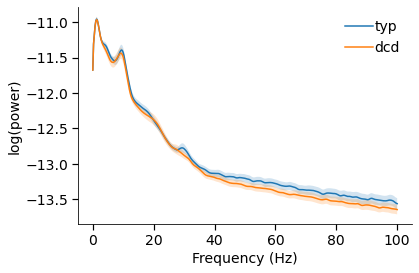

In [16]:
typ_c_psds=np.mean(np.log10(sub_psds_eye_typ[:,c_chan_idx,:]),axis=1)
m_typ=np.mean(typ_c_psds,axis=0)
se_typ=np.std(typ_c_psds,axis=0)/np.sqrt(typ_c_psds.shape[0])

dcd_c_psds=np.mean(np.log10(sub_psds_eye_dcd[:,c_chan_idx,:]),axis=1)
m_dcd=np.mean(dcd_c_psds,axis=0)
se_dcd=np.std(dcd_c_psds,axis=0)/np.sqrt(dcd_c_psds.shape[0])
plt.plot(freqs,m_typ,label='typ')
plt.fill_between(freqs, m_typ-se_typ, m_typ+se_typ, alpha=.2)
plt.plot(freqs,m_dcd,label='dcd')
plt.fill_between(freqs, m_dcd-se_dcd, m_dcd+se_dcd, alpha=.2)
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('log(power)')


Text(0, 0.5, 'Power')

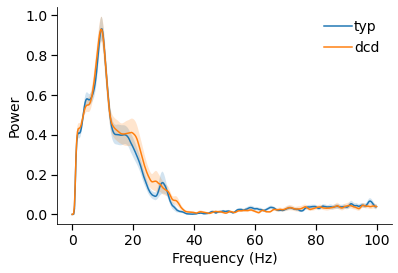

In [17]:
typ_c_psds=np.mean(sub_periodic_typ[:,c_chan_idx,:],axis=1)
typ_c_psds[typ_c_psds<0]=0
m_typ=np.mean(typ_c_psds,axis=0)
se_typ=np.std(typ_c_psds,axis=0)/np.sqrt(typ_c_psds.shape[0])

dcd_c_psds=np.mean(sub_periodic_dcd[:,c_chan_idx,:],axis=1)
dcd_c_psds[dcd_c_psds<0]=0
m_dcd=np.mean(dcd_c_psds,axis=0)
se_dcd=np.std(dcd_c_psds,axis=0)/np.sqrt(dcd_c_psds.shape[0])
plt.plot(freqs,m_typ,label='typ')
plt.fill_between(freqs, m_typ-se_typ, m_typ+se_typ, alpha=.2)
plt.plot(freqs,m_dcd,label='dcd')
plt.fill_between(freqs, m_dcd-se_dcd, m_dcd+se_dcd, alpha=.2)
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')


In [19]:
typ_c_psds=np.mean(sub_periodic_typ[:,c_chan_idx,:],axis=1)
typ_c_psds[typ_c_psds<0]=0
m_typ=np.mean(typ_c_psds,axis=0)

dcd_c_psds=np.mean(sub_periodic_dcd[:,c_chan_idx,:],axis=1)
dcd_c_psds[dcd_c_psds<0]=0
m_dcd=np.mean(dcd_c_psds,axis=0)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Peak: freq=9.75, val=0.930276911531739, width=6.0, range=6.75-12.75
Distance to nearest original peak=0.0
Peak: freq=4.25, val=0.46900893182753334, width=4.0, range=2.25-6.25
Distance to nearest original peak=0.75
Peak: freq=17.75, val=0.3896786358765654, width=7.5, range=14.0-21.5
Distance to nearest original peak=0.5
Peak: freq=29.75, val=0.15893521578454692, width=4.5, range=27.5-32.0
Distance to nearest original peak=0.0
Peak: freq=22.75, val=0.11530482156106737, width=4.5, range=20.5-25.0
Distance to nearest original peak=5.5
Peak: freq=97.75, val=0.06668187925341144, width=32.5, range=81.5-114.0
Distance to nearest original peak=0.0
Peak: freq=58.5, val=0.03292198986869426, width=10.0, range=53.5-63.5
Distance to nearest original peak=0.0
Peak: freq=71.5, val=0.022375818851364974, width=4.5, range=69.25-73.75
Distance to nearest original peak=0.0
Peak: freq=49.5, val=0.013115549792423761, width=4.0, range=47.5-51.5
Distance to nearest original peak=0.25


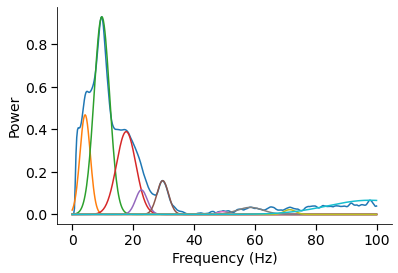

In [20]:
foi_pk_freqs_typ,foi_pk_vals_typ,foi_fwhms_typ,foi_ranges_typ=define_fois(freqs, m_typ)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Peak: freq=9.5, val=0.928056152976055, width=7.0, range=6.0-13.0
Distance to nearest original peak=0.0
Peak: freq=19.5, val=0.4074730175262106, width=10.0, range=14.5-24.5
Distance to nearest original peak=0.25
Peak: freq=4.0, val=0.32811677447806875, width=2.5, range=2.75-5.25
Distance to nearest original peak=5.5
Peak: freq=29.0, val=0.11614706105865429, width=5.5, range=26.25-31.75
Distance to nearest original peak=1.75
Peak: freq=34.25, val=0.05786844024083012, width=4.0, range=32.25-36.25
Distance to nearest original peak=7.0
Peak: freq=95.5, val=0.04565620787688048, width=56.5, range=67.25-123.75
Distance to nearest original peak=0.0
Peak: freq=56.25, val=0.008305540212803532, width=4.5, range=54.0-58.5
Distance to nearest original peak=0.0


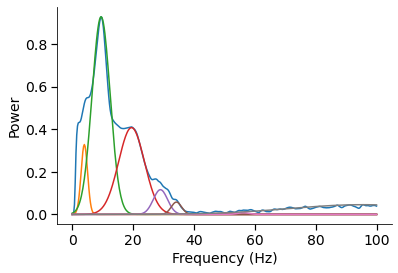

In [21]:
foi_pk_freqs_dcd,foi_pk_vals_dcd,foi_fwhms_dcd,foi_ranges_dcd=define_fois(freqs, m_dcd)


In [22]:
fname = "processed_psd_typ.mat"
output_path = op.join('/home/bonaiuto/dcd_ross/data/derivatives/NEARICA_behav/',fname)
scipy.io.savemat(output_path,
                 {
                     'frex': freqs,
                     'subj_id': np.hstack([sub_eye_typ_ids, sub_task_typ_ids]),
                     'psd': sub_psds_typ,
                     'periodic': sub_periodic_typ,
                     'aperiodic': sub_aperiodic_typ,
                     'foi_pk_freqs': foi_pk_freqs_typ,
                     'foi_pk_vals': foi_pk_vals_typ,
                     'foi_fwhms': foi_fwhms_typ,
                     'foi_ranges': foi_ranges_typ
                 })  

In [23]:
fname = "processed_psd_dcd.mat"
output_path = op.join('/home/bonaiuto/dcd_ross/data/derivatives/NEARICA_behav/',fname)
scipy.io.savemat(output_path,
                 {
                     'frex': freqs,
                     'subj_id': np.hstack([sub_eye_dcd_ids, sub_task_dcd_ids]),
                     'psd': sub_psds_dcd,
                     'periodic': sub_periodic_dcd,
                     'aperiodic': sub_aperiodic_dcd,
                     'foi_pk_freqs': foi_pk_freqs_dcd,
                     'foi_pk_vals': foi_pk_vals_dcd,
                     'foi_fwhms': foi_fwhms_dcd,
                     'foi_ranges': foi_ranges_dcd
                 })  